In [1]:
import numpy as np
import pandas as pd
import sqlite3
from datetime import timedelta
from sqlalchemy import create_engine
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)
pd.set_option('display.precision', 3)

MAX_INGRESS_P = 12000
MAX_INGRESS_N = 1000
MAX_EGRESS_P = 12000
MAX_EGRESS_N = 1000

#Always starts with a clean table to store python
#data cleaning results 
def create_clean_table(table_name):
    conn = sqlite3.connect('mta.db')

    #Creating a cursor object using the cursor() method
    cursor = conn.cursor()
    cursor.execute('DROP TABLE IF EXISTS {};'.format(table_name))
    conn.commit()
    cursor.execute('''CREATE TABLE {}(
    UNIT TEXT, SCP TEXT, CA TEXT, STATION TEXT,
    LINENAME TEXT, ENTRIES INTEGER,EXITS INTEGER,
    Year INTEGER, WEEK INTEGER,
    PRIMARY KEY(UNIT,SCP,CA,STATION,LINENAME, Year,Week)
    );'''.format(table_name))
    conn.commit()
    conn.close()
    return

def proj1_clean(datafile):
    df=pd.read_csv(datafile,converters={'DATE':pd.to_datetime})
    df.columns = [column.strip() for column in df.columns]
    df['Ingress'] = df['ENTRIES'].diff()
    df['Egress']= df.iloc[:,10].diff()
    errcnt=[0]*7
    max_row = len(df)  
    
    full_unit_name= df['UNIT'] + df['SCP']
    full_unit1 = full_unit_name.shift(1)
    
    #boolean series indicates if current row is the same turnstile as previous row
    same_unit = full_unit1.eq(full_unit_name)
    df.iloc[0,11] = 0
    df.iloc[0,12] = 0
 
    # Set Ingress to 0 for any row when it is not the same unit as the result
    # of diff() from above is only valid for rows belong to the same unit
    df['Ingress'] = df['Ingress'] * same_unit  #element wise multiply with 1/0    
    df['Egress'] = df['Egress'] * same_unit

    # Set Ingress to -(Ingress) for any row if  Ingress  < 0 
    # and the next row is also negative. This account for persistent counting down
    # for counters installed incorrectly
    smallN_Check = df['Ingress'] <= 0
    shifted=smallN_Check.shift(-1)
    shifted[max_row-1]=False
    df['Ingress'] = (1-(smallN_Check & shifted) *2) * df['Ingress']
    errcnt[0] = smallN_Check.sum()
    
    # Set Ingress to 0 for any row when it is > MAX_INGRESS_P    
    Max_Check = df['Ingress'] < MAX_INGRESS_P
    # Set Ingress to 0 for any row when it is < -MAX_INGRESS_N    
    MaxN_Check = df['Ingress'] > -MAX_INGRESS_N
    df['Ingress'] = df['Ingress'] * MaxN_Check * Max_Check  #element wise multiply with 1/0
    saved_mask = MaxN_Check & Max_Check
    errcnt[1] = max_row - Max_Check.sum()
    errcnt[2] = max_row - MaxN_Check.sum()  

    
    # Set Egress to -(Engress) for any row when  Engress <0       
    smallN_Check = df['Egress'] <= 0
    shifted=smallN_Check.shift(-1)
    shifted[max_row-1]=False
    df['Egress'] = (1-(smallN_Check & shifted) *2) * df['Egress']  
    errcnt[3] = smallN_Check.sum()
    
    # Set Egress to 0 for any row when it is > MAX_EGRESS_P    
    Max_Check = df['Egress'] < MAX_EGRESS_P
    # Set Engress to 0 for any row when it is < -MAX_EGRESS_N    
    MaxN_Check = df['Egress'] > -MAX_EGRESS_N
    df['Egress'] = df['Egress'] * MaxN_Check * Max_Check  #element wise multiply with 1/0
    saved_mask = saved_mask & MaxN_Check & Max_Check
    errcnt[4] = max_row - Max_Check.sum()
    errcnt[5] = max_row - MaxN_Check.sum()
    
    #This includes all the main correction made to the Ingress/Egress data 
    df['Mask']=~saved_mask    
    df['Week']=df.DATE.dt.isocalendar().week
#    df['DATE_TIME']=pd.to_datetime(df['DATE']+df['TIME'],format='%m/%d/%Y%H:%M:%S') 
    df['Net']=df['Ingress']-df['Egress'] 
    weekly=df.groupby(['UNIT','SCP','C/A','STATION','LINENAME'])[['Ingress','Egress']].sum().reset_index()
    
    #Add date to the weekly result 
    weekly['Year']=year=df.iloc[0,6].isocalendar()[0]
    weekly['Week']=week=df.iloc[0,6].isocalendar()[1]
    return errcnt,weekly

In [2]:
create_clean_table('mta_station')

In [6]:
datafiles=['210612','200613','190615','180609','170610','160611','150613']
for name in datafiles:
    datafile='http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'.format(name)
    errcnt,w1=proj1_clean(datafile)
    w1.to_csv('mta{}_{}.csv'.format(w1.loc[0,'Year'],w1.loc[0,'Week']),
              header=False,index=False)

In [12]:
!echo "UNIT,SCP,CA,STATION,LINENAME,ENTRIES,EXITS,Year,Week" >mta.csv
!cat *.csv >> mta.csv
week=pd.read_csv('mta.csv')

cat: mta.csv: input file is output file


In [ ]:
#week.columns=['UNIT','SCP','CA','STATION','LINENAME','ENTRIES','EXITS','Year','Week']

In [14]:
week.groupby(['UNIT','Year']).ENTRIES.sum()

UNIT  Year
R001  2015    189574.0
      2016    188537.0
      2017    217946.0
      2018    213668.0
      2019    211718.0
                ...   
R572  2017    111844.0
      2018    123392.0
      2019    125802.0
      2020     19458.0
      2021     44318.0
Name: ENTRIES, Length: 3267, dtype: float64

In [15]:
week['Net']=week['ENTRIES']-week['EXITS']

In [16]:
week['Total']=week['ENTRIES']+week['EXITS']

In [17]:
wk_res=week.groupby(['Year'])[['Net','Total','ENTRIES','EXITS']].sum()

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

From this Figure, total subway ridership per week dropped from around 60 millions pre-COVID, to 15 million per week at worst, and has sinced recovered to near 30 millions per week.
One point to note is that, entries used to be larger than exits by a large margin, and this trend ahs reversed post COVID.
In figure 2, we can see entries used to be about 56% of total traffic, while exits only account for 44% total traffic. This is been reversed post COVID.

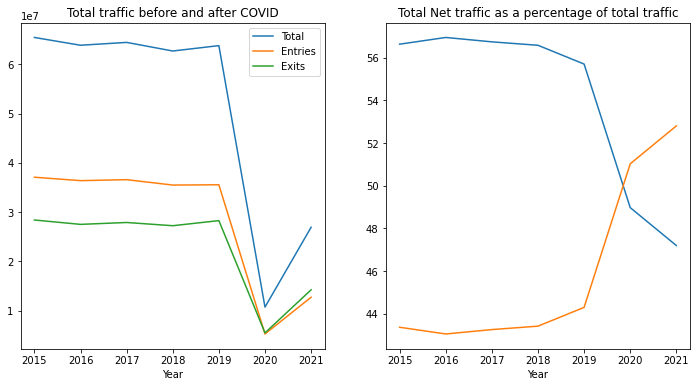

In [19]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.title('Total traffic before and after COVID')
plt.plot(wk_res.index,wk_res.Total,label='Total')
plt.plot(wk_res.index,wk_res.ENTRIES,label='Entries')
plt.plot(wk_res.index,wk_res.EXITS,label='Exits')
plt.xlabel('Year')
plt.legend()
plt.subplot(1,2,2)
plt.plot(wk_res.index,wk_res.ENTRIES/wk_res.Total * 100,label='Entries')
plt.plot(wk_res.index,wk_res.EXITS/wk_res.Total * 100,label='Exits')
plt.title('Total Net traffic as a percentage of total traffic')
plt.xlabel('Year');


We will next examine the change on stations. We have a Box plot to show the distribution of 
Entries per station as a percentage of total traffic across the years. 
At 2020, we can see the distribution change. 
So many stations are seeing the shift, rather than a few large stations.

In [22]:
week['ratio']=week['ENTRIES']/week['Total']
week_station = week.groupby(['UNIT','Year'])[['ENTRIES','EXITS']].sum().reset_index()
week_station['Net']=week_station['ENTRIES']-week_station['EXITS']
week_station['Total']=week_station['ENTRIES']+week_station['EXITS']

<AxesSubplot:title={'center':'ratio'}, xlabel='Year'>

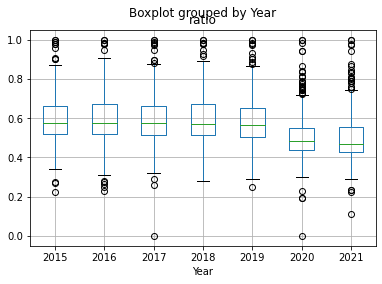

In [23]:
week_station['ratio']=week_station['ENTRIES']/week_station['Total']
week_station.boxplot(column=['ratio'],by='Year')

In [24]:
week_station_2020=week_station[ week_station['Year']==2020]

We will seperate out the data in year 2020, then merge the dataframe with the original one
so we can compare the data in other years with data in 2020.

In [25]:
week_station = pd.merge(week_station,week_station_2020,on=['UNIT'])
week_station['ratio_diff']=week_station['ratio_x'] - week_station['ratio_y']

In [26]:
result_2019=week_station[week_station['Year_x']==2019].copy()
result_2019['ratio_diff']=result_2019['ratio_x']-result_2019['ratio_y']
result_2019.describe()

,Year_x,ENTRIES_x,EXITS_x,Net_x,Total_x,ratio_x,Year_y,ENTRIES_y,EXITS_y,Net_y,Total_y,ratio_y,ratio_diff
count,469.0,469.000,469.000,469.000,4.690e+02,469.000,469.0,469.000,469.000,469.000,469.000,469.000,469.000
mean,2019.0,75760.742,60243.386,15517.356,1.360e+05,0.589,2020.0,11148.186,11613.064,-464.878,22761.249,0.509,0.080
std,0.0,80094.225,73913.605,22897.676,1.524e+05,0.112,0.0,9749.397,11236.185,3757.973,20699.827,0.110,0.063
min,2019.0,475.000,0.000,-95682.000,5.490e+02,0.248,2020.0,0.000,0.000,-17395.000,2.000,0.000,-0.143
25%,2019.0,26913.000,16418.000,908.000,4.369e+04,0.507,2020.0,5176.000,4398.000,-2223.000,9826.000,0.439,0.048
50%,2019.0,46595.000,33508.000,10138.000,7.789e+04,0.563,2020.0,8002.000,7793.000,-420.000,15901.000,0.486,0.077
75%,2019.0,97838.000,73684.000,25327.000,1.643e+05,0.653,2020.0,13744.000,14677.000,1535.000,27558.000,0.553,0.102
max,2019.0,622414.000,578091.000,124301.000,1.201e+06,1.000,2020.0,70446.000,80983.000,11693.000,147321.000,1.000,0.865


We then look at the change in the ratio across the stations. We can see many stations are seeing the shift in rations. About 50% of the stations, are seeing a change anywhere from 5% to 10% change. We will next try to examine the change in net traffic terms, rather than in ratio terms. 

<AxesSubplot:>

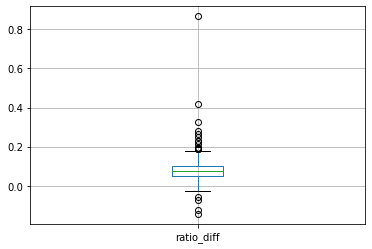

In [27]:
result_2019.boxplot(column=['ratio_diff'])

In [28]:
result_2019['Net_diff']=result_2019['Net_x']-result_2019['Net_y']

In [29]:
result_2019.describe()

,Year_x,ENTRIES_x,EXITS_x,Net_x,Total_x,ratio_x,Year_y,ENTRIES_y,EXITS_y,Net_y,Total_y,ratio_y,ratio_diff,Net_diff
count,469.0,469.000,469.000,469.000,4.690e+02,469.000,469.0,469.000,469.000,469.000,469.000,469.000,469.000,469.000
mean,2019.0,75760.742,60243.386,15517.356,1.360e+05,0.589,2020.0,11148.186,11613.064,-464.878,22761.249,0.509,0.080,15982.235
std,0.0,80094.225,73913.605,22897.676,1.524e+05,0.112,0.0,9749.397,11236.185,3757.973,20699.827,0.110,0.063,21334.768
min,2019.0,475.000,0.000,-95682.000,5.490e+02,0.248,2020.0,0.000,0.000,-17395.000,2.000,0.000,-0.143,-85254.000
25%,2019.0,26913.000,16418.000,908.000,4.369e+04,0.507,2020.0,5176.000,4398.000,-2223.000,9826.000,0.439,0.048,2633.000
50%,2019.0,46595.000,33508.000,10138.000,7.789e+04,0.563,2020.0,8002.000,7793.000,-420.000,15901.000,0.486,0.077,10094.000
75%,2019.0,97838.000,73684.000,25327.000,1.643e+05,0.653,2020.0,13744.000,14677.000,1535.000,27558.000,0.553,0.102,24429.000
max,2019.0,622414.000,578091.000,124301.000,1.201e+06,1.000,2020.0,70446.000,80983.000,11693.000,147321.000,1.000,0.865,124117.000


We know check the change in net traffic flow in 2019 compared to 2020.

In [30]:
week_station[week_station['Year_x']==2019].Net_x.sum()

7277640.0

In [31]:
week_station[week_station['Year_x']==2020].Net_x.sum()

-219788.0

We then sum up the change of net traffic, and it is 7.5 million, across 470 stations.

In [32]:
result_2019.Net_diff.sum()

7495668.0

In [33]:
len(result_2019)

469

We check the sum of the stations with most changes from 400 to 470, it is 3.8 million.

In [34]:
result_2019.Net_diff.sort_values()[400:].sum()

3824534.0

We check the sum of the stations 0 to 400, it is 3.8 million.

In [35]:
result_2019.Net_diff.sort_values()[0:400].sum()

3671134.0

We then get a list of statons and see which statons have the msot changes.

In [36]:
result_2019.Net_diff.sort_values()[400:]

4        35406.0
1428     35500.0
1936     37083.0
1268     37333.0
2183     37360.0
          ...   
144      83168.0
88       90743.0
67      107283.0
74      114477.0
214     124117.0
Name: Net_diff, Length: 69, dtype: float64

In [37]:
result_2019.loc[214,'UNIT']

'R033'

In [38]:
result_2019.loc[74,'UNIT']

'R012'

From the table we see R033 station is "42 ST-TIMES SQ", Time Square station, and
and R012 is "34 ST-PENN STA", The train Station Penn Station.